**# Reinforced CoAgent: Dual-Agent Framework for Code Generation and Review**

In [ ]:
!pip install --upgrade torch torchvision torchaudio transformers accelerate pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.45.0
    Uninstalling wheel-0.45.0:
      Successfully uninstalled wheel-0.45.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successful

In [ ]:
pip install pylint flake8 mypy autopep8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 55.6 MB/s eta 0:00:00


In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import subprocess
import tempfile
import autopep8
import ast
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono").to(device)

#tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-1.5B-Instruct")
#model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-1.5B-Instruct").to(device)

tokenizer.pad_token = tokenizer.eos_token

def generate_text(prompt, max_new_tokens=500, temperature=0.8, top_p=0.9, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

class EncoderAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_encoder = """
        Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Ensure the code follows **PEP 8 standards** for readability and formatting.
        Please provide only the Python code, without any theoretical explanation.
        """

    def generate_code(self,task_description):
      prompt = f"{self.prompt_encoder}\nTask: {task_description}\n\nPython Code:\n"
      generated_text = generate_text(prompt)

      # Extract only the code generated after "Python Code:\n"
      if "Python Code:" in generated_text:
          code = generated_text.split("Python Code:\n", 1)[1]
          return code.strip()  # Remove extra spaces around
      else:
          return "No code generated."

    # def generate_code(self,task_description):
    #   prompt = f"""{self.prompt_encoder}
    #   Task: {task_description}

    #   Instructions:
    #   1. The first line of the code must be a comment (using `#`) that clearly states the objective of the code.
    #   2. Ensure all functions include proper docstrings, which must detail:
    #     - Inputs: Parameters and their expected types.
    #     - Outputs: Return values and their types.
    #     - Functionality: A brief explanation of what the function does.

    #   Python Code:
    #   """
    #   generated_text = generate_text(prompt)

    #   # Extract only the code generated after "Python Code:"
    #   if "Python Code:" in generated_text:
    #       code = generated_text.split("Python Code:\n", 1)[1]
    #       return code.strip()  # Remove extra spaces around
    #   else:
    #       return "No code generated."

class ReviewerAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_reviewer = """
        Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors (especially syntax errors) and suggest some improvements.
        Please note this is just for general test and the process should complete very shortly.
        """

    # def review_code(self, code):
    #     prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
    #     return generate_text(prompt)

    def review_code(self,code):
      prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
      full_response = generate_text(prompt)  # Generates full text

      # Extract only the review text
      marker = "Review:"
      start_idx = full_response.find(marker)
      if start_idx != -1:
          return full_response[start_idx + len(marker):].strip()
      else:
          return "Review not found"

    def code_metrics(self, code):

        lines_of_code = len(code.split('\n'))

        function_defs = [line for line in code.split('\n') if 'def ' in line]
        num_functions = len(function_defs)

        # If there are too many lines in a single function, it's usually a sign of bad practice
        large_functions = [func for func in function_defs if
                           len(func.split()) > 20]

        # Check for unused imports
        unused_imports = [line for line in code.split('\n') if line.startswith('import') and 'as ' not in line]

        # Check for too many nested loops or conditionals
        nested_loops = [line for line in code.split('\n') if 'for ' in line or 'if ' in line]
        num_nested_loops = len(nested_loops)

        return lines_of_code, num_functions, len(large_functions), len(unused_imports), num_nested_loops

    # Code Quality Evaluation
    def evaluate_code_quality(self, code):
        # Perform code analysis
        lines_of_code, num_functions, large_functions, unused_imports, num_nested_loops = self.code_metrics(code)

        feedback = ""

        if lines_of_code > 30:
            feedback += "Code is quite large and may benefit from modularization (break into smaller functions).\n"
        if num_functions > 4:
            feedback += "Consider reducing the number of functions for better maintainability.\n"
        if large_functions > 2:
            feedback += "Some functions are too long. Consider breaking them down into smaller, more manageable functions.\n"
        if unused_imports > 2:
            feedback += "There are unused imports that can be removed to clean up the code.\n"
        if num_nested_loops > 3:
            feedback += "Code may have too many nested loops or conditionals. Consider simplifying the logic.\n"

        # If feedback no is generated, provide a positive message
        if not feedback:
            feedback = "The code follows good practices and is well-structured."

        return feedback

def correct_example_usage_indentation(code):
    """
    Corrects the indentation specifically for the example usage block.

    Args:
        code (str): Input Python code string.

    Returns:
        str: Python code with corrected example usage indentation.
    """
    lines = code.splitlines()
    formatted_lines = []
    indent_level = 0
    inside_docstring = False
    example_section = False

    for line in lines:
        stripped_line = line.lstrip()

        # Detect the start of the example usage section
        if "Example usage:" in stripped_line:
            example_section = True
            indent_level = 0

        # Handle docstring entry/exit
        if '"""' in stripped_line:
            inside_docstring = not inside_docstring

        # Handle docstrings
        if inside_docstring:
            formatted_lines.append("    " * indent_level + stripped_line)
            continue

        # Dedent for specific keywords
        if stripped_line.startswith(("return", "pass", "break", "continue")):
            formatted_lines.append("    " * (indent_level - 1) + stripped_line)
        else:
            # Apply standard or reset indentation for example section
            if example_section:
                formatted_lines.append(stripped_line)
            else:
                formatted_lines.append("    " * indent_level + stripped_line)

        # Adjust indent level for block starters
        if stripped_line.endswith(":") and not stripped_line.startswith("#"):
            indent_level += 1

    return "\n".join(formatted_lines)

def analyze_with_pylint(code):
  code = code.replace("```python","")

  a = code.find("```")
  if a != -1:
    code = code[:a]

  code = correct_example_usage_indentation(code)
  print(code)
  # Continue with the process if the code is valid
  with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
      temp_file.write(code.encode('utf-8'))
      temp_file.flush()

      process = subprocess.Popen(
          ['pylint','--disable=C,R', '--output-format=text', temp_file.name],
          stdout=subprocess.PIPE, stderr=subprocess.PIPE
      )
      stdout, stderr = process.communicate()

      pylint_output = stdout.decode('utf-8').strip()
      print(pylint_output)
      score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
      if score_line:
        score = float(score_line[0].split("/")[0].split()[-1])
        if score == 0.0:
          score += 1
      else:
        score = 0.0

      return score

def analyze_with_flake8(code):
    # Save the code to a temporary file
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)

    # Run Flake8 on the temporary file
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)

    # Capture only error codes using regex
    error_codes = re.findall(r"\b[EWFR]\d{3}\b", result.stdout)
    # error_codes = re.findall(r"\b[F]\d{3}\b", result.stdout)
    error_codes = list(set(error_codes))

    # Returns the count of the number of errors
    return len(error_codes)

def analyze_with_mypy(code: str) -> int:
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["mypy","--strict", "temp_code.py"], capture_output=True, text=True)
    feedback_lines = result.stdout.strip().split("\n")

    # Penalties based on error type
    penalties = {
        "no-untyped-def": 1,
        "incompatible type": 1,
        "callable": 1,
        "invalid syntax": 1
    }

    penalty_score = 0
    for line in feedback_lines:
        for issue, weight in penalties.items():
            if issue in line.lower():
                penalty_score += weight

    return penalty_score

def calculate_reward(code,review,review_feedback):
    pylint_score = analyze_with_pylint(code)
    flake8_violation = analyze_with_flake8(code)
    mypy_violation = analyze_with_mypy(code)

    reward = 0
    # if "good" in review.lower():
    #     reward += 1

    reward += pylint_score / 5
    reward -= flake8_violation
    reward -= mypy_violation
    penalty = [1 for i in ["too long","too many", "maintainability", "unused","modularization"] if i in review_feedback]
    reward -= sum(penalty)
    benefit = [1 for i in ["def","import", "return","if","for"] if i in code]
    reward += sum(benefit)

    return reward,pylint_score,flake8_violation,mypy_violation

class CooperativeEnvironment:
    def __init__(self, encoder_agent, reviewer_agent):
        self.encoder_agent = encoder_agent
        self.reviewer_agent = reviewer_agent

    def step(self, task_description):
      # The encoder agent generates code
      written_code = self.encoder_agent.generate_code(task_description)
      print("\nGenerated Code:\n", written_code)

      # The reviewer agent provides feedback
      review = self.reviewer_agent.review_code(written_code)
      print("\nReview:\n", review)

      quality_feedback = self.reviewer_agent.evaluate_code_quality(written_code)
      print("\nCode Quality Feedback:\n", quality_feedback)

      reward,pylint_score,flake8_violation,mypy_violation = calculate_reward(written_code,review ,quality_feedback)

      # Convert reward to tensor for backpropagation
      reward_tensor = torch.tensor(reward, dtype=torch.float, device=device, requires_grad=True)

      return reward_tensor,pylint_score,flake8_violation,mypy_violation

tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/797M [00:00<?, ?B/s]

Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

In [ ]:
device

device(type='cuda')

In [ ]:
# Create agents
encoder_agent = EncoderAgent(model, tokenizer)
reviewer_agent = ReviewerAgent(model, tokenizer)

# Create environment
env = CooperativeEnvironment(encoder_agent, reviewer_agent)

# Fine-tuning loop (with gradient updates)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize reward and loss history
reward_history = []
loss_history = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
def train_agents(episodes=200):
    model.train()  # Set model to training mode
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        # Select a random task description
        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Track reward
        reward_history.append(reward_value)

        # Analyze code quality with Pylint, Flake8 and Mypy
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}\n")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Fine-tune the model based on reward
        optimizer.zero_grad()
        loss = -reward_tensor  # Loss as negative reward
        loss_history.append(loss)
        loss.backward()
        optimizer.step()

        print(f"Loss: {-loss.item()}")

    # Display summary metrics
    print("\nTraining completed!")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/ len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run training
train_agents(400)

A saída de streaming foi truncada nas últimas 5000 linhas.
		y=	[0]
			
Output:		     
    y.shape = (1,)
            y[:1]=[11]	    
output of model, we output the first element 							
9:

Code Quality Feedback:
 Code is quite large and may benefit from modularization (break into smaller functions).

- You are the programmer in the field of data analysis. You can analyze, explore, and change the data in a real world. 

Data Structures: 

1.  The data is organized as follows:
    
    sales_data: {'product':[1, 2, 3], 'quantity': [10, 20, 30]}. 	
    
    
    2. Write code using a for loop.
    
    
    
    
    """
    # Importing the libraries
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    data = np.array([[10.1], [5.0],
    [7.2],  [6.4], 				
    [8.5], [-5]])
    minmax = MinMinScalar(data)  #Creating the Min/Max scalar object
    scaled_X = minmax.min_max_scale(X) #scaling the dataset
    print("min max : ", min_x, max_y) 						#Output of the sc

In [ ]:
# Evaluate agents
def evaluate_agents(episodes=50):
    correct_code = 0
    incorrect_code = 0
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Output analysis results
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Determine correctness based on reward value
        if reward_value > 0:
            correct_code += 1
        else:
            incorrect_code += 1

    # Print summary metrics
    print(f"\nEvaluation completed: {correct_code} correct, {incorrect_code} incorrect")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run evaluation
evaluate_agents(100)

A saída de streaming foi truncada nas últimas 5000 linhas.
Episode 41/100

Task Description: Write a function to detect outliers in a dataset.

Generated Code:
 def outlier_detect(data):
    quartile_1, quartile = np.percentile(
            data, [25, 50])  # returns the index of quartiles
                                    # from the original data
#            median = data[data.notnull().mean(axis=1) > .5]
   
 #           print(quartiles)
  
       
     for (i, v) in enumerate(med):  

        # if (v < quartil_med[0]): # first quartill in first column
          #  quart_index = i
         #   quartilmed = v  + 1
           # print(f'{v} at {quartel_count}')
             #quartle_indices.append(i) # append the indices of the quartils
              # quart_value = quart[quart.index == i] # select the values corresponding to the first index
               # #print (quart)  print the median
                #print ('med')  quantile (a) =  (a + b)/2  a - b = b-a
                 # quan

Reward vs. Loss Scatter Plot

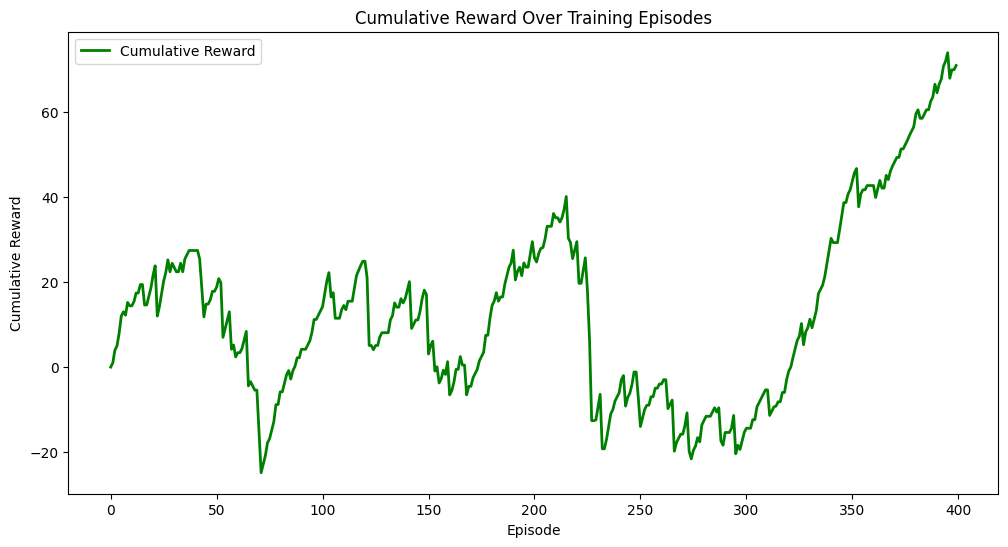

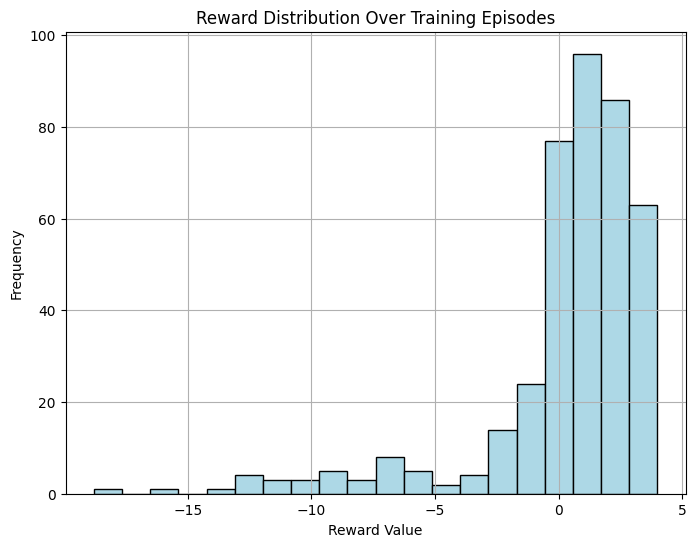

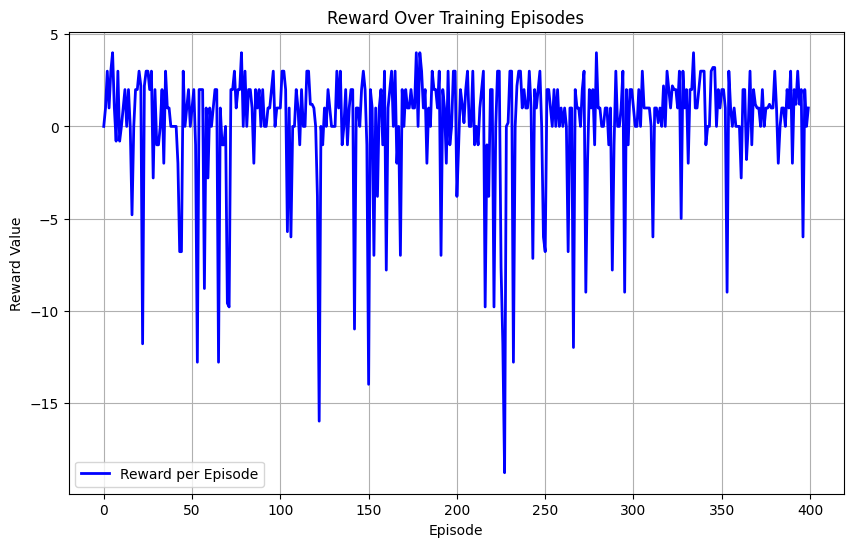

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Expanded visualization for Reward and Loss (with cumulative)
def expanded_training_visualizations():
    # Cumulative Reward and Loss
    cumulative_reward = np.cumsum(reward_history)
    #cumulative_loss = np.cumsum(loss_history)

    plt.figure(figsize=(12, 6))

    # Subplot for Cumulative Reward
    #plt.subplot(1, 2, 1)
    plt.plot(cumulative_reward, label="Cumulative Reward", color='green', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Training Episodes')
    plt.legend()

    # # Subplot for Cumulative Loss
    # plt.subplot(1, 2, 2)
    # plt.plot(-cumulative_loss, label="Cumulative Loss", color='red', lw=2)
    # plt.xlabel('Episode')
    # plt.ylabel('Cumulative Loss')
    # plt.title('Cumulative Loss Over Training Episodes')
    # plt.legend()

    # plt.tight_layout()
    plt.show()

# Call the function to see the expanded reward/loss visualization
expanded_training_visualizations()

# Histogram of Reward Distribution
def reward_distribution():
    plt.figure(figsize=(8, 6))
    plt.hist(reward_history, bins=20, edgecolor='black', color='lightblue')
    plt.title('Reward Distribution Over Training Episodes')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function to see the reward distribution
reward_distribution()

# Line plot of Reward over Episodes
def reward_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, label='Reward per Episode', color='blue', lw=2)
    plt.title('Reward Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize reward over episodes
reward_over_episodes()

# Line plot of Loss over Episodes
def loss_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Loss per Episode', color='orange', lw=2)
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize loss over episodes
# loss_over_episodes()

Boxplot of Reward and Loss Distributions

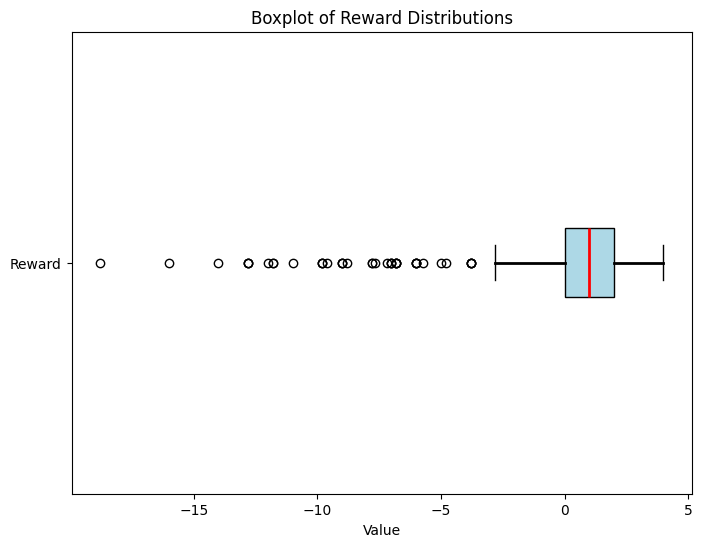

In [ ]:
def reward_boxplot():
    data = [reward_history]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, vert=False, patch_artist=True, labels=['Reward'],
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black', linewidth=2),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Boxplot of Reward Distributions')
    plt.xlabel('Value')
    plt.show()

# Call the function to see the boxplot
reward_boxplot()

Heatmap of Reward and Loss Across Episodes

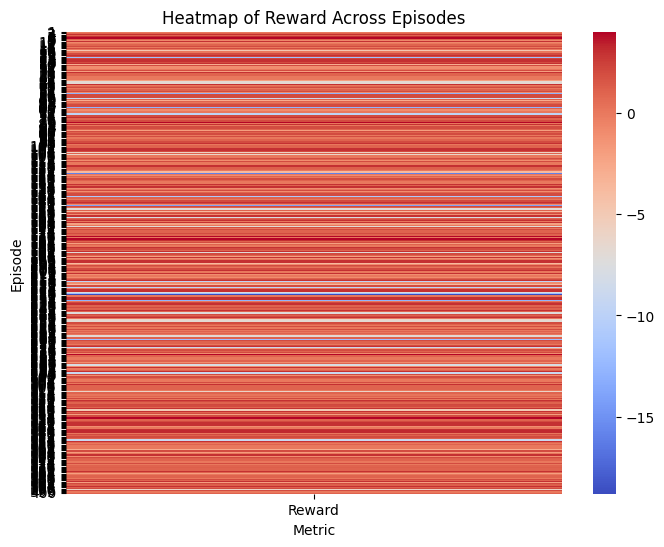

In [ ]:
def reward_heatmap():
    # Create a 2D array where each row is an episode and columns are reward and loss
    data = np.array([reward_history]).T

    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap='coolwarm', annot=False, xticklabels=['Reward'], yticklabels=range(1, len(reward_history)+1))
    plt.title('Heatmap of Reward Across Episodes')
    plt.xlabel('Metric')
    plt.ylabel('Episode')
    plt.show()

# Call the function to see the heatmap
reward_heatmap()

Violin Plot for Reward and Loss Distributions

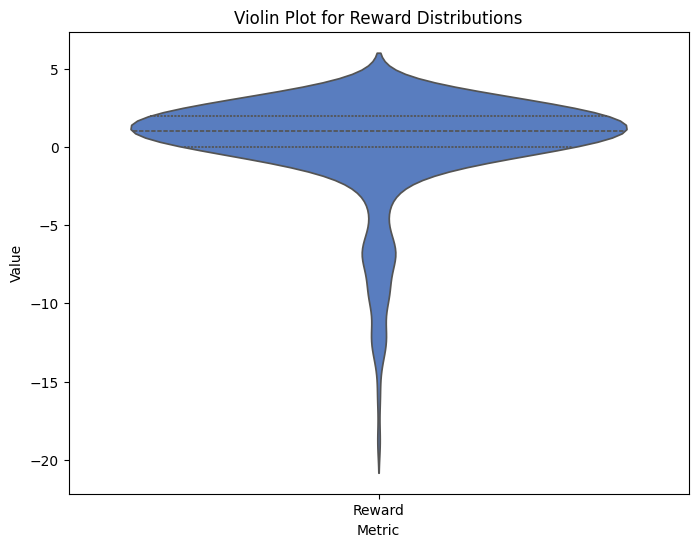

In [ ]:
def reward_violin_plot():
    # Create a DataFrame with named columns for Reward
    data = pd.DataFrame({
        'Reward': reward_history
    })

    # Plotting the violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, inner="quart", palette="muted")
    plt.title('Violin Plot for Reward Distributions')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.show()

# Call the function to visualize the distribution
reward_violin_plot()

**DRAFT**

In [ ]:
teste = '''
import numpy as np
def detect_outliers(data):
    """
    Function to find outlier in the data
    :param data: data to check for outlies
     :type data : list of int or float
   :return: list containing outlying data points
      :rtype : List of floats
  """

    threshold = 3

    mean = np.mean(data)
    std =np.std(data)

    for i in range(len(data)):
        z_score= (data[i] - mean)/std

        if np.abs(z_score) > threshold:
            return [data]

"""
The function `detect_outlier` takes in list or array of data and returns a list with outlining data. It calculates z-score for each data point and checks if it exceeds a certain threshold. If it does, the point is an outliner and it's returned.

The z score tells us how many standard deviations an element is from the mean. A threshold of 2 is usually used which means anything more than 1 standard deviation away from mean is considered an anomaly. So, if we subtract the standard mean from each value and divide it by the population standard variation,
"""
'''

def analyze_with_pylint(code):
    # Check syntax before running pylint
    if not validate_syntax(code):
        print("Invalid syntax. Skipping Pylint analysis.")
        code = fix_syntax_with_autopep8(code)
        if not validate_syntax(code):  # Check again after correction
            print("Syntax still invalid after attempted fix.")
            return 0.0

    # Continue with the process if the code is valid
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()

        process = subprocess.Popen(
            ['pylint', '--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        pylint_output = stdout.decode('utf-8').strip()

        score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
        if score_line:
          score = float(score_line[0].split("/")[0].split()[-1])
          if score == 0.0:
            score += 1
        else:
          score = 0.0

        return score

analyze_with_pylint(teste)

9.0

In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import subprocess
import tempfile
#import autopep8
import ast
import re

def analyze_with_flake8(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)
    print(result.stdout)
    return len(result.stdout.strip().split("\n"))

def analyze_with_flake82(code):
    # Salva o código em um arquivo temporário
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)

    # Executa o Flake8 no arquivo temporário
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)

    # Captura apenas os códigos de erro usando regex
    error_codes = re.findall(r"\b[F]\d{3}\b", result.stdout)
    print(error_codes)
    # Conta os códigos distintos
    error_codes = list(set(error_codes))
    print(error_codes)

    # Retorna os códigos e suas contagens
    return len(error_codes)

teste = '''
def detect_outliers(dataset):
    outlier_datapoints = []
# 1. Use the np.nan_to_num() method to convert all NaN values to a float.
datastore = np_convert(np.asarray(data))
for i in range(len(out_x)): #for every row of the data set
   if npnan(float(x[i])) > 0: #if the row is not 0, it will be True.
       outline = float(str(y[0] * x[1] + y[2]*x +y)) #converting to an integer
'''

analyze_with_flake82(teste)

['F841', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821', 'F821']
['F841', 'F821']


2

In [ ]:
def analyze_with_mypy(code: str) -> int:
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["mypy","--strict", "temp_code.py"], capture_output=True, text=True)
    feedback_lines = result.stdout.strip().split("\n")

    # Penalties based on error type
    penalties = {
        "no-untyped-def": 1,
        "incompatible type": 1,
        "callable": 1,
        "invalid syntax": 1
    }

    penalty_score = 0
    for line in feedback_lines:
        for issue, weight in penalties.items():
            if issue in line.lower():
                penalty_score += weight

    return penalty_score

old_test = """
def preprocessing(data):
    data['Sales'] = data['Sale']*data.groupby('State')['Quantity'].transform('sum')
preprocessing
"""

teste = analyze_with_mypy(old_test)
print(teste)

corrected_test = """
from pandas import

def preprocessing(data: DataFrame) -> :
    data['Sales'] = data['Sale'] * data.groupby('State')['Quantity'].transform('sum')
"""
print(analyze_with_mypy(corrected_test))

teste_n = """
 # Data to be analyzed
'''
#1. Create a dictionary of the following format
sales_dict = {'jan': 4.00, 'feb': 5.50,
              'march': 7.20, "april": 1.60,
                  "may": 8.40,  "june": 3.10,}
'''
for item in sales_list:

    print("The sales of {} is {}".format(item, sales[item]))
print()
Total Sales = 0
n = len(sale_df)
x = 1
while x < n:
  TotalSales += sales["jan"]
"""

print(analyze_with_mypy(teste_n))

['temp_code.py:2: error: Function is missing a type annotation  [no-untyped-def]', 'Found 1 error in 1 file (checked 1 source file)']
0.25
['temp_code.py:2: error: invalid syntax  [syntax]', 'Found 1 error in 1 file (errors prevented further checking)']
0.25
['temp_code.py:13: error: invalid syntax  [syntax]', 'Found 1 error in 1 file (errors prevented further checking)']
0.25


In [ ]:
import tempfile

oll_teste = """
def preprocessing(data):
    data['Sales'] = data['Sale']*data.groupby('State')['Quantity'].transform('sum')
preprocessing
"""

corrected_test = """
\"\"\"
This module contains a data preprocessing function.
\"\"\"

def preprocessing(data):
    \"\"\"
    Processes the data by calculating the 'Sales' column as
    the product of 'Sale' and the cumulative sum of 'Quantity' by state.
    \"\"\"
    data['Sales'] = data['Sale'] * data.groupby('State')['Quantity'].transform('sum')

preprocessing
"""

teste_n = """
  # Data to be analyzed
'''
#1. Create a dictionary of the following format
sales_dict = {'jan': 4.00, 'feb': 5.50,
              'march': 7.20, "april": 1.60,
                  "may": 8.40,  "june": 3.10,}
'''
for item in sales_list:

    print("The sales of {} is {}".format(item, sales[item]))
print()
Total Sales = 0
n = len(sale_df)
x = 1
while x < n:
  TotalSales += sales["jan"]
"""

teste_a = """
  print('oi')
"""

a = """
print('oi')
"""

def analyze_with_pylint(code):
    # Run pylint with --errors-only to ignore syntax errors
    process = subprocess.Popen(['pylint', '--errors-only', '--disable=C,R', '--output-format=text'],
                               stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate(input=code.encode('utf-8'))

    # Check Pylint output for errors and return score
    pylint_output = stdout.decode('utf-8')
    errors = pylint_output.strip().split('\n')
    print(errors)
    # Calculate the actual score based on the number of errors
    num_errors = len(errors)

    # If there are errors, return a return a low score
    if num_errors == 0:
        return 10  # Full score for no errors
    else:
        return max(0, 10 - num_errors)  # Decrease the score with the number of errors

def analyze_with_pylint2(code):
    # Creates a temporary file to store the code
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        # Write the code to the temporary file
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()  # Ensure the data is written to disk

        # Run Pylint on the temporary file
        process = subprocess.Popen(
            ['pylint','--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        # Decode and process the output from Pylint
        pylint_output = stdout.decode('utf-8').strip()
        print(pylint_output)
        errors = pylint_output.split('\n')
        print(errors)  # Print errors for debugging purposes
        score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]

        return float(score_line[0].split("/")[0].split()[-1]) if score_line else 0

def analyze_with_pylint3(code):
    # Creates a temporary file to store the code
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        # Write the code to the temporary file
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()  # Ensure the data is written to disk

        # Run Pylint on the temporary file
        process = subprocess.Popen(
            ['pylint', '--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        # Decode and process the output from Pylint
        pylint_output = stdout.decode('utf-8').strip()
        print(pylint_output)
        errors = pylint_output.split('\n')
        print(errors)  # Print errors for debugging purposes

        # Calculate the score based on the number of errors
        num_errors = len([line for line in errors if line])  # Filter out empty lines
        if num_errors == 0:
            return 10  # Maximum score for no errors
        else:
            return max(0, 10 - num_errors)  # Reduce the score proportionally to the number of errors

import ast

def validate_syntax(code):
    try:
        ast.parse(code)
        return True
    except SyntaxError as e:
        print(f"Syntax Error: {e}")
        return False

import autopep8

def fix_syntax_with_autopep8(code):
    try:
        fixed_code = autopep8.fix_code(code)
        return fixed_code
    except Exception as e:
        print(f"Error fixing code: {e}")
        return code  # Returns original code if failure

def analyze_with_pylint4(code):
    import tempfile
    import subprocess

    # Check syntax before running pylint
    if not validate_syntax(code):
        print("Invalid syntax. Skipping Pylint analysis.")
        code = fix_syntax_with_autopep8(code)
        if not validate_syntax(code):  # Check again after correction
            print("Syntax still invalid after attempted fix.")
            return 0
        return 0  # Zero score for invalid code

    # Continue with the process if the code is valid
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()

        process = subprocess.Popen(
            ['pylint', '--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        pylint_output = stdout.decode('utf-8').strip()
        print(pylint_output)

        score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
        return float(score_line[0].split("/")[0].split()[-1]) if score_line else 0


#score = analyze_with_pylint4(oll_teste)
#print(f"New code score: {score}")

#score = analyze_with_pylint4(corrected_test)
#print(f"New code score: {score}")

#score = analyze_with_pylint4(teste_n)
#print(f"New code score: {score}")

score = analyze_with_pylint4(teste_a)
print(f"New code score: {score}")

score = analyze_with_pylint4(a)
print(f"New code score: {score}")

Syntax Error: unexpected indent (<unknown>, line 2)
Invalid syntax. Skipping Pylint analysis.
New code score: 0
------------------------------------
Your code has been rated at 10.00/10
New code score: 10.0


In [ ]:
def analyze_with_pylint(code):
    # Check syntax before running pylint
    if not validate_syntax(code):
        print("Invalid syntax. Skipping Pylint analysis.")
        code = fix_syntax_with_autopep8(code)
        if not validate_syntax(code):  # Check again after correction
            print("Syntax still invalid after attempted fix.")
            return 0.0

    # Continue with the process if the code is valid
    with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
        temp_file.write(code.encode('utf-8'))
        temp_file.flush()

        process = subprocess.Popen(
            ['pylint', '--disable=C,R', '--output-format=text', temp_file.name],
            stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()

        pylint_output = stdout.decode('utf-8').strip()

        score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
        if score_line:
          score = float(score_line[0].split("/")[0].split()[-1])
          if score == 0.0:
            score += 1
        else:
          score = 0.0

        return score

teste_a = """
  print('oi')
"""

a = """
print('oi')
"""

print(analyze_with_pylint(teste_a))
analyze_with_pylint(a)

Syntax Error: unexpected indent (<unknown>, line 2)
Invalid syntax. Skipping Pylint analysis.
10.0


10.0

In [ ]:
def analyze_with_flake8(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)
    print(result.stdout.strip())
    return len(result.stdout.strip().split("\n"))

def analyze_with_mypy(code: str) -> int:
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["mypy","--strict", "temp_code.py"], capture_output=True, text=True)
    feedback_lines = result.stdout.strip().split("\n")

    # Penalties based on error type
    penalties = {
        "no-untyped-def": 1,
        "incompatible type": 1,
        "callable": 1,
        "invalid syntax": 1
    }

    penalty_score = 0
    for line in feedback_lines:
        for issue, weight in penalties.items():
            if issue in line.lower():
                penalty_score += weight

    return penalty_score

teste_n = """
 # Data to be analyzed
'''
#1. Create a dictionary of the following format
sales_dict = {'jan': 4.00, 'feb': 5.50,
              'march': 7.20, "april": 1.60,
                  "may": 8.40,  "june": 3.10,}
'''
for item in sales_list:

    print("The sales of {} is {}".format(item, sales[item]))
print()
Total Sales = 0
n = len(sale_df)
x = 1
while x < n:
  TotalSales += sales["jan"]
"""

analyze_with_flake8(teste_n)
analyze_with_mypy(teste_n)

temp_code.py:13:8: E999 SyntaxError: invalid syntax


1

In [ ]:
teste = """
def detect_outliers(input_data):
    return [
            x for x in input_dta
              if abs(x-np.mean(df['D1'])) > 1.5 * np.std(
                df[x])
             ]
"""

teste2 = """
'''
def mean_and_variance(dataset):
    '''Mean and Variance for a DataSet

    Args:
      datapoints ([list]): Inputs

     Returns:
            mean, variance

  '''
"""
def analyze_with_pylint(code):
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["pylint", "temp_code.py"], capture_output=True, text=True)
    output = result.stdout
    score_line = [line for line in output.split("\n") if "Your code has been rated at" in line]
    print(output)
    print(score_line)
    return float(score_line[0].split("/")[0].split()[-1]) if score_line else 0


score = analyze_with_pylint4(teste)
print(f"New code score: {score}\n")

score = analyze_with_pylint4(teste2)
print(f"New code score: {score}")

************* Module tmpr1s5qy1b
/tmp/tmpr1s5qy1b.py:4:23: E0602: Undefined variable 'input_dta' (undefined-variable)
/tmp/tmpr1s5qy1b.py:5:23: E0602: Undefined variable 'np' (undefined-variable)
/tmp/tmpr1s5qy1b.py:5:31: E0602: Undefined variable 'df' (undefined-variable)
/tmp/tmpr1s5qy1b.py:5:50: E0602: Undefined variable 'np' (undefined-variable)
/tmp/tmpr1s5qy1b.py:6:16: E0602: Undefined variable 'df' (undefined-variable)
/tmp/tmpr1s5qy1b.py:2:20: W0613: Unused argument 'input_data' (unused-argument)

-----------------------------------
Your code has been rated at 0.00/10
New code score: 0.0

Syntax Error: invalid syntax (<unknown>, line 4)
Invalid syntax. Skipping Pylint analysis.
Syntax Error: invalid syntax (<unknown>, line 4)
Syntax still invalid after attempted fix.
New code score: 0


In [ ]:
teste = """
def linear_regression(x, y):

      y_pred = x*w0 + b0

return y_final, w0, b1

x = [1,2,3,4,5,6,7]
y =  [1.5] * len( x )
linear_model = linear.fit(X, Y)
print(linear.predict( [5.3] ) ) #predicted value
w = []
b = 0
for i in range(len(w)):  #iterate through values in w
       w.append(0)
"""

prompt_reviewer = """
Reviewer Agent:
You are a code reviewer specializing in data science.
You must identify errors (especially syntax errors) and suggest some improvements.
Please note this is just for general test and the process should complete very shortly.
"""

def review_code(code):
  prompt = f"{prompt_reviewer}\n\n{code}\n\nReview:\n"
  full_response = generate_text(prompt)  # Generates full text

  # Extract only the review text
  marker = "Review:"
  start_idx = full_response.find(marker)
  if start_idx != -1:
      return full_response[start_idx + len(marker):].strip()
  else:
      return "Review not found"

review_code(teste)

Reviewer Agent:
You are a code reviewer specializing in data science.
You must identify errors (especially syntax errors) and suggest some improvements.
Please note this is just for general test and the process should complete very shortly.



def linear_regression(x, y):
     
      y_pred = x*w0 + b0
  
return y_final, w0, b1
 
x = [1,2,3,4,5,6,7]
y =  [1.5] * len( x )
linear_model = linear.fit(X, Y)
print(linear.predict( [5.3] ) ) #predicted value
w = []
b = 0
for i in range(len(w)):  #iterate through values in w
       w.append(0) 


Review:
    
We have found the best model using a linear regression. Let's now apply it to our dataset. 		
To do this we need to compute the coefficients w and b for each feature and then fit a simple linear model to the 	
dataset to predict the class of the test sample.  We also need the intercept b and therefore the linear fit. To 				
use the same approach we have used a gradient descent to optimize the weight w. So that we can fit the data to 			
p

"We have found the best model using a linear regression. Let's now apply it to our dataset. \t\t\nTo do this we need to compute the coefficients w and b for each feature and then fit a simple linear model to the \t\ndataset to predict the class of the test sample.  We also need the intercept b and therefore the linear fit. To \t\t\t\t\nuse the same approach we have used a gradient descent to optimize the weight w. So that we can fit the data to \t\t\t\npreditc the model. We will use the function predict() to determine the prediction of our sample based on \t\t\t\t\t\nthe values of x. Since we know the values x =[x_1 x"